<a href="https://colab.research.google.com/github/moosunny/NLP-Practice/blob/main/Transformer_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!gdown https://drive.google.com/uc?id=1r4ZnFJOStyBlNRx7snBQ-Iq2GNyJKL6t -O '대화체.xlsx'

Downloading...
From: https://drive.google.com/uc?id=1r4ZnFJOStyBlNRx7snBQ-Iq2GNyJKL6t
To: /content/대화체.xlsx
100% 9.57M/9.57M [00:00<00:00, 23.3MB/s]


# Transformer 구조

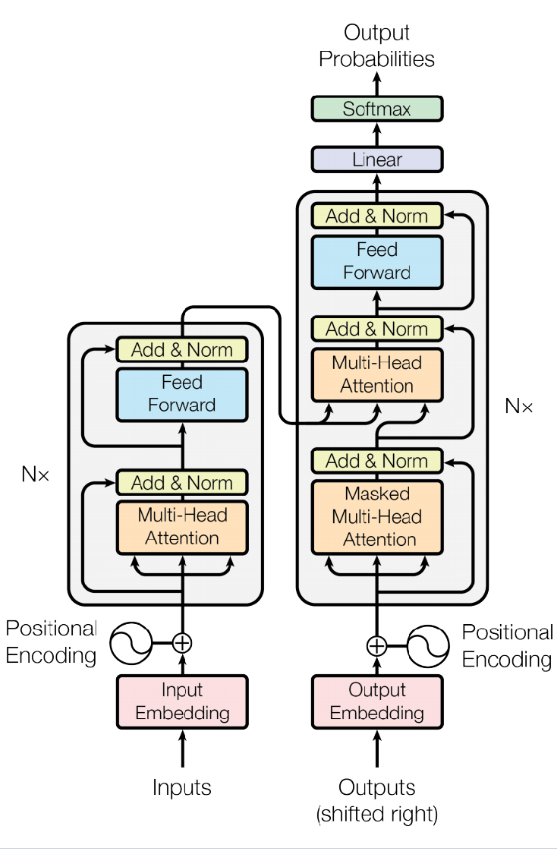

In [2]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

df_communication = pd.read_excel(r'/content/대화체.xlsx')
df_communication

,대분류,소분류,상황,Set Nr.,발화자,원문,번역문
0,비즈니스,회의,의견 교환하기,1,A-1,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...
1,비즈니스,회의,의견 교환하기,1,B-1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...
2,비즈니스,회의,의견 교환하기,1,A-2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ..."
3,비즈니스,회의,의견 교환하기,1,B-2,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o..."
4,비즈니스,회의,의견 교환하기,2,A-1,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...
...,...,...,...,...,...,...,...
99995,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",24999,B-2,"저희가 가격표 배치를 잘못해서 혼동을 드렸나 봐요, 죄송해요.",It seems that we didn't place the price tags c...
99996,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-1,"백화점 포인트로 계산하고 싶은데, 가능한가요?",Can I pay using the department store points?
99997,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,B-1,"네, 물론이죠, 전화번호 입력해주시면 됩니다.","Yes, of course, you just need to enter your ph..."
99998,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-2,"입력했어요, 전액 백화점 포인트로 결제하고 싶어요.","I entered it, I want to pay it with all the de..."


In [34]:
# 띄어쓰기 토크나이저
corpus_list = list(df_communication['원문'])
word_list = []

# 문장 맨 앞뒤 시퀀스 토큰 삽입
for idx, corpus in enumerate(corpus_list):
  corpus_list[idx] = corpus.split(sep = ' ')
  corpus_list[idx].insert(0, '</s>')
  corpus_list[idx].append('</s>')
  word_list.extend(corpus.split(sep = ' '))

# 가장 긴 문장 길이를 구함 -> 나머지 문장에 <pad> 토큰을 추가
max_len = max(map(len, word_list))
print('가장 긴 문장의 길이:', max_len)
word_list = [] # word list 리셋

for corpus in corpus_list:
  if len(corpus) < max_len:
    corpus.extend(['<pad>'] * (max_len - len(corpus)))
    word_list.extend(corpus)

print("중복 제거 전 단어 개수:", len(word_list))
print("중복 제거 후 단어 개수: ", len(set(word_list)))

# 편의상 <pad> 토큰은 단어 모음집의 0번 인덱스로 표기하는 경우가 많음
unique_words = list(set(word_list))
if '<pad>' in unique_words:
  unique_words.remove('<pad>')
  unique_words.remove('</s>')
  unique_words.insert(0, '<pad>')
  unique_words.insert(1, '</s>')

str_idx = {word: idx for idx, word in enumerate(unique_words)}
idx_str = {idx: word for idx, word in enumerate(unique_words)}

가장 긴 문장의 길이: 18
중복 제거 전 단어 개수: 1792692
중복 제거 후 단어 개수:  116613


In [36]:
# 문장 -> 정수 인코딩 -> 단어 디코딩
def encode_sentence(sentence, vocab):
    return [vocab.get(word) for word in sentence]

def decode_sentence(sentence, vocab):
    return [idx_str[idx] for idx in sentence]

print("원본 문장:",corpus_list[0])
print("원본 문장 encoding 후:",encode_sentence(corpus_list[0], str_idx))
print("encoding 문장 -> decoding:",decode_sentence(encode_sentence(corpus_list[0], str_idx), idx_str))

원본 문장: ['</s>', '이번', '신제품', '출시에', '대한', '시장의', '반응은', '어떤가요?', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
원본 문장 encoding 후: [1, 107378, 44660, 25306, 16719, 57706, 44642, 12554, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
encoding 문장 -> decoding: ['</s>', '이번', '신제품', '출시에', '대한', '시장의', '반응은', '어떤가요?', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [49]:
input_sentences = [encode_sentence(sentence, str_idx) for sentence in corpus_list] # 입력 문장 정수 인코딩 적용
input_sentence = input_sentences[0][1:8]
decode_sentence(input_sentence, idx_str)

['이번', '신제품', '출시에', '대한', '시장의', '반응은', '어떤가요?']

In [53]:
# 임베딩을 통한 토큰 벡터화
import torch
import torch.nn as nn

embedding_dim = 16

# 토큰 임베딩 레이어 -> Unique 단어 개수 만큼 num_embedding 정의
emb_layer = nn.Embedding(num_embeddings=len(str_idx), embedding_dim=embedding_dim)

input_emb = emb_layer(torch.tensor(input_sentence)) # (문장길이, 임베딩 차원)
input_emb = input_emb.unsqueeze(0) # 배치화를 위해 (1, 문장 길이, 임베딩 차원)

torch.Size([1, 7, 16])

In [55]:
# 포지셔널 인코딩 레이어
pos_emb_layer = nn.Embedding(num_embeddings=max_len, embedding_dim= embedding_dim)
pos_input = torch.arange(len(input_sentence))
pos_enc = pos_emb_layer(torch.arange(len(input_sentence)))
print("pos_enc.shape:", pos_enc.shape)
# 토큰 임베딩
token_emb = emb_layer(torch.tensor(input_sentence))
token_emb = token_emb.unsqueeze(0)
# 토큰 임베딩 + 포지션 인코딩
input_emb = token_emb + pos_enc
input_emb.shape

pos_enc.shape: torch.Size([7, 16])


torch.Size([1, 7, 16])

In [57]:
# 쿼리, 키, 벨류 벡터 생성을 위한 레이어
head_dim = 16

# 쿼리, 키, 벨류를 계산하기 위한 변환
fc_q = nn.Linear(embedding_dim, head_dim)
fc_k = nn.Linear(embedding_dim, head_dim)
fc_v = nn.Linear(embedding_dim, head_dim)

# 변환 수핼
query = fc_q(input_emb)
key = fc_k(input_emb)
value = fc_v(input_emb)
print("query.shape:", query.shape)

query.shape: torch.Size([1, 7, 16])


In [59]:
# Scale dot product attention
from math import sqrt
import torch.nn.functional as F

def compute_attention(query, key, value, is_casual = False):
  k_dim = query.size(-1)
  scores = query @ key.transpose(-2, -1) / sqrt(k_dim) # (1, 문장 길이, 문장 길이)
  weight = F.softmax(scores, dim = -1)
  return weight @ value

print("원본 입력 형태:",input_emb.shape)

after_attention = compute_attention(query, key, value)
print("attention 적용 후 형태:",after_attention.shape)

원본 입력 형태: torch.Size([1, 7, 16])
attention 적용 후 형태: torch.Size([1, 7, 16])


In [44]:
# torch.utils.data.Dataset을 활용한 데이터 셋 생성 클래스
import torch
import torch.nn

class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):
    return self.df.loc[index, '원문'], self.df.loc[index, '번역문']

Custom_DS = CustomDataset(df_communication)
Custom_DS[0]

('이번 신제품 출시에 대한 시장의 반응은 어떤가요?',
 "How is the market's reaction to the newly released product?")